# ThaiNER (Bi-LSTM CRF)

using pytorch

from https://github.com/ekapolc/nlp_course/blob/master/PyTorchDemo/pytorch_tute_lstm.ipynb and https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html

By Mr.Wannaphong Phatthiyaphaibun

Bachelor of Science Program in Computer and Information Science, Nong Khai Campus, Khon Kaen University

https://iam.wannaphong.com/

E-mail : wannaphong@kkumail.com

Thank you Faculty of Applied Science and Engineering, Nong Khai Campus, Khon Kaen University for server.

## Load Data

In [1]:
import dill
with open('datatrain.data', 'rb') as file:
 datatofile = dill.load(file)

In [2]:
datatofile[1]

[('สงสัย', 'NCMN', 'O'),
 ('ติด', 'VACT', 'O'),
 ('หวัด', 'NCMN', 'O'),
 ('นก', 'DDAC', 'O'),
 (' ', 'NCMN', 'O'),
 ('อีก', 'DDBQ', 'O'),
 ('คน', 'NCMN', 'O'),
 ('ยัง', 'XVBM', 'O'),
 ('น่า', 'VSTA', 'O'),
 ('ห่วง', 'NCMN', 'O')]

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
from sklearn.model_selection import cross_validate,train_test_split
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

print(torch.__version__)

1.0.0


In [4]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#torch.backends.cudnn.benchmark=torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.long
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [5]:
word_ner=[]
for i in datatofile:
    t1=[]
    t2=[]
    for j in i:
        t1.append(j[0])
        t2.append(j[2])
    word_ner.append((t1,t2))

In [6]:
tagged_sents=word_ner

In [32]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix else to_ix["UNK"] for w in seq]
    return torch.tensor(idxs, dtype=LongTensor, device=device)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [8]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size, device=device))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2,device=device),
                torch.randn(2, 1, self.hidden_dim // 2,device=device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000., device=device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1,device=device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=LongTensor, device=device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000., device=device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [9]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 64
HIDDEN_DIM = 128

In [10]:
#split data into train set and test set
train_size = int(len(tagged_sents) * 0.8)
train_sents = tagged_sents[:train_size]
test_sents = tagged_sents[train_size:]

In [11]:
train_sents[0]

(['http',
  '://',
  'www',
  '.',
  'bangkokhealth',
  '.',
  'com',
  '/',
  'healthnews',
  '_',
  'htdoc',
  '/',
  'healthnews',
  ' ',
  '_',
  ' ',
  'detail',
  '.',
  'asp',
  '?',
  'Number',
  '=',
  '10506'],
 ['B-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL'])

## Preparing the Data

In [12]:
word_list=[]
pos_list=[]

for sent,tags in train_sents:
    for word in sent:
        word_list.append(word)
    for tag in tags:
        pos_list.append(tag)

#Word to Index
word_list.append("UNK") #Special Token for unknown words
pos_list.append(START_TAG)
pos_list.append(STOP_TAG)
all_words = sorted(set(word_list))
all_pos = sorted(set(pos_list))
#del word_list, pos_list
word_to_ix = dict((c, i) for i, c in enumerate(all_words)) #convert word to index 
pos_to_ix = dict((c, i) for i, c in enumerate(all_pos)) #convert pos to index

In [13]:
print(pos_to_ix) # NER tags

{'<START>': 0, '<STOP>': 1, 'B-DATE': 2, 'B-EMAIL': 3, 'B-LAW': 4, 'B-LEN': 5, 'B-LOCATION': 6, 'B-MONEY': 7, 'B-ORGANIZATION': 8, 'B-PERCENT': 9, 'B-PERSON': 10, 'B-PHONE': 11, 'B-TIME': 12, 'B-URL': 13, 'B-ZIP': 14, 'I-DATE': 15, 'I-EMAIL': 16, 'I-LAW': 17, 'I-LEN': 18, 'I-LOCATION': 19, 'I-MONEY': 20, 'I-ORGANIZATION': 21, 'I-PERCENT': 22, 'I-PERSON': 23, 'I-PHONE': 24, 'I-TIME': 25, 'I-URL': 26, 'O': 27}


In [14]:
ix_to_word = dict((v,k) for k,v in word_to_ix.items()) #convert index to word
ix_to_pos = dict((v,k) for k,v in pos_to_ix.items())  #convert index to word

## Preparing the Data for PyTorch

In [15]:
model = BiLSTM_CRF(len(word_to_ix), pos_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
model.to(device)

BiLSTM_CRF(
  (word_embeds): Embedding(12739, 64)
  (lstm): LSTM(64, 64, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=28, bias=True)
)

In [16]:
tag_to_ix=pos_to_ix

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [18]:
train_sents[0]

(['http',
  '://',
  'www',
  '.',
  'bangkokhealth',
  '.',
  'com',
  '/',
  'healthnews',
  '_',
  'htdoc',
  '/',
  'healthnews',
  ' ',
  '_',
  ' ',
  'detail',
  '.',
  'asp',
  '?',
  'Number',
  '=',
  '10506'],
 ['B-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL',
  'I-URL'])

In [19]:
with torch.no_grad():
    precheck_sent = prepare_sequence(train_sents[0][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in train_sents[0][1]], dtype=LongTensor, device=device)
    print(precheck_sent)
    print(model(precheck_sent))

tensor([1671, 1072, 1767,   59, 1630,   59, 1646,   70, 1668, 1620, 1670,   70,
        1668,    0, 1620,    0, 1653,   59, 1628, 1076, 1417, 1073,  260])
(tensor(59.0233), [3, 7, 27, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [20]:
def train(sentence, tags,train=True):
    if train:
        model.train(True)
    else:
        model.eval()
    model.zero_grad()
    sentence_in = prepare_sequence(sentence, word_to_ix)
    targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=LongTensor, device=device)
    loss = model.neg_log_likelihood(sentence_in, targets)
    if train:
        loss.backward()#backprop
        optimizer.step()#update parameters
    return loss.item()

In [21]:
import time
import math

n_iters = 20
print_every = 1

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
train_losses=[]
val_losses=[]
for iter in range(1, n_iters + 1):#Epoch
    loader = tqdm(train_sents, total=len(train_sents))
    for sentence, pos_tags in loader: #Sentence
        loss = train(sentence, pos_tags) #fwd
    loader = tqdm(train_sents, total=len(train_sents))
    for sentence, pos_tags in loader: #Sentence
        val_loss = train(sentence, pos_tags,train=False) #fwd
    # Print iter number,time, loss
    if iter % print_every == 0:
        print('ep %d %d%% (%s) loss %.4f ' % (iter, iter / n_iters * 100, timeSince(start), loss))
        print('val loss %.4f ' % (val_loss))
        train_losses.append(loss)
        val_losses.append(val_loss)
        torch.save(model.state_dict(), "ner-2.pt.ep"+str(iter))

  0%|          | 0/4918 [00:00<?, ?it/s]

ep 1 5% (22m 54s) loss 5.9876 
val loss 4.3611 


  0%|          | 2/4918 [00:00<05:49, 14.08it/s]

ep 2 10% (46m 35s) loss 5.0369 
val loss 1.8872 


  0%|          | 1/4918 [00:00<11:55,  6.88it/s]

ep 3 15% (69m 35s) loss 3.4753 
val loss 1.2607 


  0%|          | 1/4918 [00:00<09:28,  8.64it/s]

ep 4 20% (91m 56s) loss 1.5467 
val loss 0.5047 


  0%|          | 2/4918 [00:00<05:53, 13.90it/s]

ep 5 25% (114m 46s) loss 1.4968 
val loss 0.6393 


  0%|          | 2/4918 [00:00<06:35, 12.44it/s]

ep 6 30% (137m 27s) loss 0.8594 
val loss 0.3064 


  0%|          | 0/4918 [00:00<?, ?it/s]

ep 7 35% (160m 22s) loss 1.1734 
val loss 0.5098 


  0%|          | 2/4918 [00:00<07:07, 11.49it/s]

ep 8 40% (183m 20s) loss 0.3145 
val loss 0.4121 


  0%|          | 2/4918 [00:00<06:28, 12.65it/s]

ep 9 45% (205m 50s) loss 0.1635 
val loss 0.1672 


  0%|          | 1/4918 [00:00<08:36,  9.52it/s]

ep 10 50% (228m 24s) loss 0.4766 
val loss 0.3157 


  0%|          | 1/4918 [00:00<09:48,  8.35it/s]

ep 11 55% (251m 5s) loss 0.1742 
val loss 0.1161 


  0%|          | 2/4918 [00:00<06:07, 13.37it/s]

ep 12 60% (274m 10s) loss 0.1705 
val loss 0.2456 


  0%|          | 1/4918 [00:00<08:15,  9.93it/s]

ep 13 65% (297m 7s) loss 0.9643 
val loss 0.1075 


  0%|          | 1/4918 [00:00<08:13,  9.96it/s]

ep 14 70% (320m 15s) loss 0.3679 
val loss 0.0522 


  0%|          | 2/4918 [00:00<05:42, 14.36it/s]

ep 15 75% (343m 11s) loss 0.0983 
val loss 0.0330 


  0%|          | 2/4918 [00:00<06:11, 13.22it/s]

ep 16 80% (365m 56s) loss 0.0351 
val loss 0.0256 


  0%|          | 2/4918 [00:00<06:50, 11.97it/s]

ep 17 85% (388m 45s) loss 0.0179 
val loss 0.0249 


  0%|          | 1/4918 [00:00<08:25,  9.72it/s]

ep 18 90% (411m 31s) loss 0.0884 
val loss 0.0323 


  0%|          | 2/4918 [00:00<06:01, 13.59it/s]

ep 19 95% (434m 13s) loss 0.0469 
val loss 0.0303 


100%|██████████| 4918/4918 [06:00<00:00, 13.64it/s]

ep 20 100% (456m 51s) loss 0.0208 
val loss 0.0150 


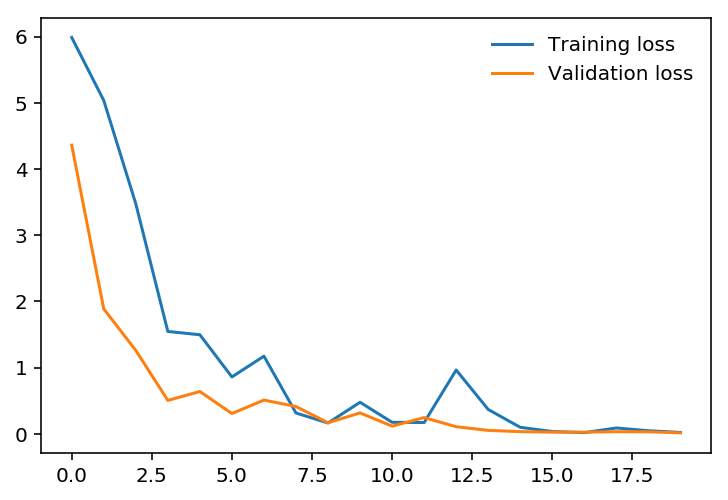

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [30]:
with torch.no_grad():
    precheck_sent = prepare_sequence(train_sents[0][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in train_sents[0][1]], dtype=LongTensor, device=device)
    print(precheck_sent)
    print(model(precheck_sent))

tensor([1671, 1072, 1767,   59, 1630,   59, 1646,   70, 1668, 1620, 1670,   70,
        1668,    0, 1620,    0, 1653,   59, 1628, 1076, 1417, 1073,  260])
(tensor(301.5559), [13, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26])


In [36]:
with torch.no_grad():
    print(model(prepare_sequence(test_sents[1][0], word_to_ix))[1])
    print(test_sents[1][0])

[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 8, 27, 8, 21, 21, 21, 21, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 2, 15, 15, 27]
['“', 'ระบบ', 'โซ', 'ตัส', 'ที่', 'ใหญ่', 'ที่สุด', ' ', 'ไม่ใช่', 'อยู่', 'ใน', 'มหาวิทยาลัย', ' ', 'ทหาร', ' ', 'เอา', 'ที่จริง', 'มีระบบ', 'ใหญ่', 'กว่า', 'นั้น', 'แต่', 'อำนาจ', 'ไม่', 'แรง', ' ', 'ระบบ', 'ราชการ', 'ทั้งหมด', 'เลย', ' ', 'โซ', 'ตัส', 'ใน', 'มหาวิทยาลัย', 'มัน', 'กระจอก', '”', ' ', 'ศาสตราจารย์', 'กิตติคุณ', 'ธงชัย', 'กล่าว', 'ใน', 'งาน', 'เสวนา', 'บันทึก', 'ข้อมูล', 'เพื่อ', 'ทวง', 'ความยุติธรรม', 'จัด', 'โดย', 'สโมสร', 'นิสิต', 'คณะรัฐศาสตร์', ' ', 'จุฬา', 'ลง', 'กร', 'ณ์', 'มหาวิทยาลัย', ' ', 'ร่วมกับ', 'โครงการ', 'บันทึก', ' ', '6', ' ', 'ตุ', 'ลา', ' ', 'ใน', 'วันที่', ' ', '24', ' ', 'กันยายน', 'ที่ผ่านมา']


In [37]:
def predict(input_sent):
    y_pred=[]
    temp=[]
    with torch.no_grad():
        precheck_sent = prepare_sequence(input_sent, word_to_ix)
        output=model(precheck_sent)[1]
        y_pred=[ix_to_pos[i] for i in output]
    
    return y_pred

In [42]:
print(test_sents[2][0])
print(predict(test_sents[2][0]))
print(test_sents[2][1])

['“', ' ', 'ไม่ใช่', 'เขา', 'ไม่รู้', 'หลายอย่าง', 'ที่', 'ทำ', 'มัน', 'เกินไป', ' ', 'แต่', 'สังคม', 'ไทย', 'เต็มไปด้วย', 'คน', 'ที่', 'ขี้ขลาด', 'ตาขาว', 'และ', 'คน', 'เหล่านั้น', 'สมควร', 'ได้รับ', 'การ', 'ดูถูก', 'ดูหมิ่น', ' ', 'คน', 'เหล่านั้น', 'ได้ยิน', 'แล้ว', 'ว่า', 'ตำรวจ', ' ', '6', ' ', 'คน', 'ถูกจับ', 'หลังจาก', 'ไม่', 'กี่', 'วันหลัง', 'วันที่', ' ', '24', ' ', 'กันยายน', ' ', '2519', ' ', 'แล้ว', 'ยัง', 'เฉย', 'อยู่', 'อีก', ' ', 'คนขี้ขลาด', 'เต็มบ้านเต็มเมือง', ' ', 'นี้', 'เรา', 'ไทยแลนด์', ' ', '4.0', ' ', 'ไทยแลนด์', 'ของ', 'คนขี้ขลาด', 'ต้อง', 'เป็น', 'นายก', 'ของ', 'ประชาชน', 'ตาดำ', ' ', 'ๆ', ' ', 'จำนวน', 'มหาศาล', ' ', 'เห็น', 'ความอยุติธรรม', 'แล้ว', 'ไม่', 'จัดการ', 'ให้', 'เรียบร้อย', ' ', 'อย่างนี้', 'ไม่', 'เรียก', 'ว่า', 'ขี้ขลาด', 'ได้', 'อย่างไร', '”', ' ', 'ศาสตราจารย์', 'กิตติคุณ', 'ธง', 'ชัย', 'กล่าว']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [43]:
for test_sent,_ in test_sents[:len(test_sents)-2]:
    print(test_sent)

['ศาสตราจารย์', 'กิตติคุณ', 'ธงชัย', ' ', 'วินิจ', 'จะ', 'กู', 'ล', ' ', 'จาก', 'สถาบัน', ' ', 'IDE-Jetro', ' ', 'ประเทศญี่ปุ่น', 'กล่าวถึง', 'ระบบ', 'โซ', 'ตัส', 'ใน', 'สังคม', 'ไทย', 'ว่า', ' ', 'ระบบ', 'โซ', 'ตัส', 'ที่', 'ใหญ่', 'ที่สุด', 'ไม่ได้', 'อยู่', 'ใน', 'มหาวิทยาลัย', ' ', 'แต่', 'เป็นระบบ', 'ของ', 'ทหาร', ' ', 'ซึ่ง', 'จริง', ' ', 'ๆ', ' ', 'แล้ว', 'ยัง', 'มีระบบ', 'โซ', 'ตัส', 'ที่', 'ใหญ่', 'กว่า', 'นั้น', 'ก็', 'คือ', 'ระบบ', 'ราชการ', 'แต่', 'อำนาจ', 'ไม่', 'แรง', 'เท่า']
['“', 'ระบบ', 'โซ', 'ตัส', 'ที่', 'ใหญ่', 'ที่สุด', ' ', 'ไม่ใช่', 'อยู่', 'ใน', 'มหาวิทยาลัย', ' ', 'ทหาร', ' ', 'เอา', 'ที่จริง', 'มีระบบ', 'ใหญ่', 'กว่า', 'นั้น', 'แต่', 'อำนาจ', 'ไม่', 'แรง', ' ', 'ระบบ', 'ราชการ', 'ทั้งหมด', 'เลย', ' ', 'โซ', 'ตัส', 'ใน', 'มหาวิทยาลัย', 'มัน', 'กระจอก', '”', ' ', 'ศาสตราจารย์', 'กิตติคุณ', 'ธงชัย', 'กล่าว', 'ใน', 'งาน', 'เสวนา', 'บันทึก', 'ข้อมูล', 'เพื่อ', 'ทวง', 'ความยุติธรรม', 'จัด', 'โดย', 'สโมสร', 'นิสิต', 'คณะรัฐศาสตร์', ' ', 'จุฬา', 'ลง', 'กร', 'ณ์', 'มหา

In [44]:
y_pred = []

for test_sent,_ in test_sents:
    try:
        temp_pred = predict(test_sent)
        y_pred.append(temp_pred)
    except:
        print(test_sent)

[]


In [45]:
test_targets =[ner1 for sent,ner1 in test_sents if sent!=[]]

In [46]:
test_sents[1]

(['“',
  'ระบบ',
  'โซ',
  'ตัส',
  'ที่',
  'ใหญ่',
  'ที่สุด',
  ' ',
  'ไม่ใช่',
  'อยู่',
  'ใน',
  'มหาวิทยาลัย',
  ' ',
  'ทหาร',
  ' ',
  'เอา',
  'ที่จริง',
  'มีระบบ',
  'ใหญ่',
  'กว่า',
  'นั้น',
  'แต่',
  'อำนาจ',
  'ไม่',
  'แรง',
  ' ',
  'ระบบ',
  'ราชการ',
  'ทั้งหมด',
  'เลย',
  ' ',
  'โซ',
  'ตัส',
  'ใน',
  'มหาวิทยาลัย',
  'มัน',
  'กระจอก',
  '”',
  ' ',
  'ศาสตราจารย์',
  'กิตติคุณ',
  'ธงชัย',
  'กล่าว',
  'ใน',
  'งาน',
  'เสวนา',
  'บันทึก',
  'ข้อมูล',
  'เพื่อ',
  'ทวง',
  'ความยุติธรรม',
  'จัด',
  'โดย',
  'สโมสร',
  'นิสิต',
  'คณะรัฐศาสตร์',
  ' ',
  'จุฬา',
  'ลง',
  'กร',
  'ณ์',
  'มหาวิทยาลัย',
  ' ',
  'ร่วมกับ',
  'โครงการ',
  'บันทึก',
  ' ',
  '6',
  ' ',
  'ตุ',
  'ลา',
  ' ',
  'ใน',
  'วันที่',
  ' ',
  '24',
  ' ',
  'กันยายน',
  'ที่ผ่านมา'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'

In [53]:
def pos_classification_report(y_true, y_pred):
 
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
    tagset = list(sorted(set(lb.classes_)))
    print(tagset)
    del tagset[len(tagset)-1] # del O
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset if cls!="O"],
        target_names = tagset,
        digits=4
    )

In [54]:
print(pos_classification_report(test_targets,y_pred))

['B-DATE', 'B-LAW', 'B-LEN', 'B-LOCATION', 'B-MONEY', 'B-ORGANIZATION', 'B-PERCENT', 'B-PERSON', 'B-PHONE', 'B-TIME', 'B-URL', 'I-DATE', 'I-LAW', 'I-LEN', 'I-LOCATION', 'I-MONEY', 'I-ORGANIZATION', 'I-PERCENT', 'I-PERSON', 'I-PHONE', 'I-TIME', 'I-URL', 'O']
                precision    recall  f1-score   support

        B-DATE     0.9056    0.7892    0.8434       389
         B-LAW     0.8367    0.5125    0.6357        80
         B-LEN     0.8889    0.7273    0.8000        11
    B-LOCATION     0.7608    0.6877    0.7224       666
       B-MONEY     0.9478    0.8074    0.8720       135
B-ORGANIZATION     0.7970    0.7077    0.7497      1365
     B-PERCENT     1.0000    0.7895    0.8824        19
      B-PERSON     0.9086    0.7391    0.8152       713
       B-PHONE     0.6667    0.4000    0.5000         5
        B-TIME     0.7529    0.6737    0.7111        95
         B-URL     0.9167    0.8462    0.8800        13
        I-DATE     0.9144    0.8423    0.8769       761
         I-LA

In [49]:
predict(["ผม","ชื่อ","นาย","บุญ","มาก"," ","ทอง","ดี"])

['O',
 'O',
 'B-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON']

In [59]:
predict(["ผม","เดิน","ทาง","ไป","เรียน","ที่","ขอนแก่น"])

['O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION']

In [50]:
len(word_to_ix)

12739

In [51]:
import dill
with open('word_to_ix.pkl', 'wb') as file:
    dill.dump(word_to_ix, file)

In [52]:
with open('pos_to_ix.pkl', 'wb') as file:
    dill.dump(pos_to_ix, file)

In [60]:
torch.save(model.state_dict(), "thainer.model")